In [1]:
%matplotlib inline
import axs
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii

import pyspark.sql.functions as sparkfunc
from pyspark.sql.window import Window

In [2]:
from pyspark.sql import SparkSession
spark_session = (SparkSession.builder
         .config('spark.master', "local[15]") # 20 when running the full crossmatch, 10 when doing validation.
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         .config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/jupyter/user/ctslater/proxy/4040")
         .enableHiveSupport()
         .getOrCreate())
spark_session

In [3]:
catalog = axs.AxsCatalog(spark_session)

Building the Detection Table
=======

In [4]:

base_path = "/epyc/data/ztf_scratch/parquet_conversion_partnership"
partnership_detections = spark_session.read.parquet(base_path + "/rc??/*/ztf_*_data.parquet")


In [5]:
partnership_detections

DataFrame[catflags_g: smallint, chi_g: float, dec: double, expid_g: int, hjd: double, mag_g: float, magerr_g: float, magerrmodel: float, localMatchID: int, mjd_g: double, programid_g: smallint, psfflux_g: float, psffluxerr_g: float, ra: double, sharp_g: float, xpos_g: float, ypos_g: float, matchid: bigint, filterid: bigint, rcID_g: bigint, fieldID_g: bigint, expid: int, mjd_r: double, mag_r: float, magerr_r: float, psfflux_r: float, psffluxerr_r: float, catflags_r: smallint, expid_r: int, xpos_r: float, ypos_r: float, chi_r: float, sharp_r: float, programid_r: smallint, rcID_r: bigint, fieldID_r: bigint, mjd_i: double, mag_i: float, magerr_i: float, psfflux_i: float, psffluxerr_i: float, catflags_i: smallint, expid_i: int, xpos_i: float, ypos_i: float, chi_i: float, sharp_i: float, programid_i: smallint, rcID_i: bigint, fieldID_i: bigint]

In [6]:
dr2_det = catalog.load("ztf_dr2_detections")

In [7]:
adj_dr2 = dr2_det.exclude_duplicates().drop("zone", "dup", "psfmag", "psfmagerr", "relphotflags", "sid", "snr", "x", "y", "z")

In [8]:
len(adj_dr2.columns)

50

In [9]:
len(partnership_detections.columns)

50

In [10]:
list(zip(partnership_detections.columns, adj_dr2.columns))

[('catflags_g', 'catflags_g'),
 ('chi_g', 'chi_g'),
 ('dec', 'dec'),
 ('expid_g', 'expid_g'),
 ('hjd', 'hjd'),
 ('mag_g', 'mag_g'),
 ('magerr_g', 'magerr_g'),
 ('magerrmodel', 'magerrmodel'),
 ('localMatchID', 'localMatchID'),
 ('mjd_g', 'mjd_g'),
 ('programid_g', 'programid_g'),
 ('psfflux_g', 'psfflux_g'),
 ('psffluxerr_g', 'psffluxerr_g'),
 ('ra', 'ra'),
 ('sharp_g', 'sharp_g'),
 ('xpos_g', 'xpos_g'),
 ('ypos_g', 'ypos_g'),
 ('matchid', 'matchid'),
 ('filterid', 'filterid'),
 ('rcID_g', 'rcID_g'),
 ('fieldID_g', 'fieldID_g'),
 ('expid', 'expid'),
 ('mjd_r', 'mjd_r'),
 ('mag_r', 'mag_r'),
 ('magerr_r', 'magerr_r'),
 ('psfflux_r', 'psfflux_r'),
 ('psffluxerr_r', 'psffluxerr_r'),
 ('catflags_r', 'catflags_r'),
 ('expid_r', 'expid_r'),
 ('xpos_r', 'xpos_r'),
 ('ypos_r', 'ypos_r'),
 ('chi_r', 'chi_r'),
 ('sharp_r', 'sharp_r'),
 ('programid_r', 'programid_r'),
 ('rcID_r', 'rcID_r'),
 ('fieldID_r', 'fieldID_r'),
 ('mjd_i', 'mjd_i'),
 ('mag_i', 'mag_i'),
 ('magerr_i', 'magerr_i'),
 ('psfflu

In [ ]:
%%time

union_table = partnership_detections.union(adj_dr2)
catalog.save_axs_table(union_table, "ztf_march2020_detections", calculate_zone=True)

Match in sections
======

In [5]:
ps1 = catalog.load("ps1")

In [4]:
ztf_march2020_detections = catalog.load("ztf_march2020_detections")
ztf_march2020_detections.createOrReplaceTempView("ztf_field")

In [16]:

def crossmatch_in_zone_band(detections_table, ps1, min_zone, max_zone, base_name):
    
    match_result = detections_table.where((detections_table['zone'] >= int(min_zone)) &
                                            (detections_table['zone'] < int(max_zone))).crossmatch(
        ps1.exclude_duplicates().select("ra", "dec", "zone", "dup", "objID",
                                        "gMeanPSFMag", "rMeanPSFMag", "iMeanPSFMag"), return_min=False)

    w = Window.partitionBy(sparkfunc.col("zone"), sparkfunc.col("expid"), sparkfunc.col("objID")).orderBy(sparkfunc.col("axsdist"))
    best_matches = match_result.withColumn("axsrownum",
                                         sparkfunc.row_number().over(w)).where(sparkfunc.col("axsrownum") == 1).drop("axsrownum")

    best_matches.createOrReplaceTempView("ztf_best_matches")

    q = spark_session.sql("SELECT objid as ps1_objid, avg(ra) as ra, avg(dec) as dec, zone, "
                          "avg(mag_g) as mean_mag_g, "
                          "avg(mag_r) as mean_mag_r, "
                          "avg(mag_i) as mean_mag_i, "
                          "stddev(ra) as ra_stddev, "
                          "stddev(dec) as dec_stddev, "                      
                          "first(gMeanPSFMag) as ps1_gMeanPSFMag, "
                          "first(rMeanPSFMag) as ps1_rMeanPSFMag, "
                          "first(iMeanPSFMag) as ps1_iMeanPSFMag, "
                          "collect_list(ra) as ra_detections, "
                          "collect_list(dec) as dec_detections, "                      
                          "collect_list(mjd_g) as mjd_g, "
                          "collect_list(mag_g) as mag_g, "
                          "collect_list(magerr_g) as magerr_g, "
                          "collect_list(psfflux_g) as psfflux_g, "
                          "collect_list(psffluxerr_g) as psffluxerr_g, " 
                          "collect_list(catflags_g) as catflags_g, "
                          "collect_list(expid_g) as expid_g, "
                          "collect_list(rcID_g) as rcID_g, "
                          "collect_list(fieldID_g) as fieldID_g, "
                          "collect_list(xpos_g) as xpos_g, "
                          "collect_list(ypos_g) as ypos_g, "
                          "count(expid_g) as nobs_g, "
                          ""
                          "collect_list(mjd_r) as mjd_r, "
                          "collect_list(mag_r) as mag_r, "
                          "collect_list(magerr_r) as magerr_r, "
                          "collect_list(psfflux_r) as psfflux_r, "
                          "collect_list(psffluxerr_r) as psffluxerr_r, "
                          "collect_list(catflags_r) as catflags_r, "
                          "collect_list(expid_r) as expid_r, "
                          "collect_list(rcID_r) as rcID_r, "
                          "collect_list(fieldID_r) as fieldID_r, "
                          "collect_list(xpos_r) as xpos_r, "
                          "collect_list(ypos_r) as ypos_r, "                      
                          "count(expid_r) as nobs_r, "
                          ""
                          "collect_list(mjd_i) as mjd_i, "
                          "collect_list(mag_i) as mag_i, "
                          "collect_list(magerr_i) as magerr_i, " 
                          "collect_list(psfflux_i) as psfflux_i, "
                          "collect_list(psffluxerr_i) as psffluxerr_i, "
                          "collect_list(catflags_i) as catflags_i, "
                          "collect_list(expid_i) as expid_i, "
                          "collect_list(rcID_i) as rcID_i, "
                          "collect_list(fieldID_i) as fieldID_i, "
                          "collect_list(xpos_i) as xpos_i, "
                          "collect_list(ypos_i) as ypos_i, " 
                          "count(expid_i) as nobs_i "                      
                          ""
                          "FROM ztf_best_matches "
                          "GROUP BY zone, objid")
    q.write.parquet("/epyc/projects2/ztf_scratch2/{:s}_zone{:05d}_{:05d}.parquet".format(base_name, min_zone, max_zone))


In [6]:
ztf_march2020_detections.select(sparkfunc.min(ztf_march2020_detections['zone']),
                                sparkfunc.max(ztf_march2020_detections['zone'])).collect()


[Row(min(zone)=3719, max(zone)=10699)]

In [11]:
zone_chunk_starts = np.arange(3700, 10750, 150)

In [ ]:
%%time
for n, (min_zone, max_zone) in enumerate(zip(zone_chunk_starts[:-1], zone_chunk_starts[1:])):
    print(n)
    crossmatch_in_zone_band(ztf_march2020_detections, ps1, min_zone, max_zone, "ztf_combined_mar2020")

0


Combine strips
========

In [26]:
union_of_shards = spark_session.read.parquet("/epyc/projects2/ztf_scratch2/ztf_combined_mar2020*.parquet")

In [ ]:
%%time
catalog.save_axs_table(union_of_shards.drop("zone"), "ztf_march2020", calculate_zone=True)

Validation
======

In [20]:
ztf_det = catalog.load("ztf_march2020_detections")

In [21]:
ztf_det.count()

258746277854

In [22]:
ztf_det_oct = catalog.load("ztf_oct19_detections")

In [23]:
ztf_det_oct.count()

199634290179

In [28]:
ztf = catalog.load("ztf_march2020")

In [29]:
ztf.count()

1302708714

In [30]:
ztf.exclude_duplicates().count()

1116187337

In [10]:
ztf

AxsFrame[ps1_objid: bigint, ra: double, dec: double, zone: bigint, mean_mag_g: double, mean_mag_r: double, mean_mag_i: double, ra_stddev: double, dec_stddev: double, ps1_gMeanPSFMag: double, ps1_rMeanPSFMag: double, ps1_iMeanPSFMag: double, ra_detections: array<double>, dec_detections: array<double>, mjd_g: array<double>, mag_g: array<float>, magerr_g: array<float>, psfflux_g: array<float>, psffluxerr_g: array<float>, catflags_g: array<smallint>, expid_g: array<int>, rcID_g: array<bigint>, fieldID_g: array<bigint>, xpos_g: array<float>, ypos_g: array<float>, nobs_g: bigint, mjd_r: array<double>, mag_r: array<float>, magerr_r: array<float>, psfflux_r: array<float>, psffluxerr_r: array<float>, catflags_r: array<smallint>, expid_r: array<int>, rcID_r: array<bigint>, fieldID_r: array<bigint>, xpos_r: array<float>, ypos_r: array<float>, nobs_r: bigint, mjd_i: array<double>, mag_i: array<float>, magerr_i: array<float>, psfflux_i: array<float>, psffluxerr_i: array<float>, catflags_i: array<smallint>, expid_i: array<int>, rcID_i: array<bigint>, fieldID_i: array<bigint>, xpos_i: array<float>, ypos_i: array<float>, nobs_i: bigint]

In [5]:

def histogram2d(axsframe, cond1, cond2, numbins1, numbins2, min1=None, max1=None, min2=None, max2=None):
    """
    Uses `cond1` and `cond2` colunm expressions to obtain data for 2D histogram calculation. The data on
    x axis will be binned into `numbins1` bins. The data on y axis will be binned into `numbins2` bins.
    If `min1`, `max1`, `min2` or `max2` are not spacified, they will be calculated using an additional pass
    through the data.
    The method returns x, y and z 2-D numpy arrays (see numpy.mgrid) which can be used as an input to
    `matplotlib.pcolormesh`.
    :param cond1: Column expression determining the data on x axis.
    :param cond2: Column expression determining the data on y axis.
    :param numbins1: Number of bins for x axis.
    :param numbins2: Number of bins for y axis.
    :param min1: Optional minimum value for x axis data.
    :param max1: Optional maximum value for x axis data.
    :param min2: Optional minimum value for y axis data.
    :param max2: Optional maximum value for y axis data.
    :return: x, y, z 2-D numpy "meshgrid" arrays (see numpy.mgrid)
    """
    colname1 = "axs_hist_col1"
    colname2 = "axs_hist_col2"
    res = axsframe._df.select(cond1.alias(colname1), cond2.alias(colname2))

    if min1 is None or max1 is None or min2 is None or max2 is None:
        mm = res.select(F.min(res[colname1]).alias("min1"), F.max(res[colname1]).alias("max1"),
                        F.min(res[colname2]).alias("min2"), F.max(res[colname2]).alias("max2")).\
            collect()
        (min1, max1, min2, max2) = (mm[0]["min1"], mm[0]["max1"], mm[0]["min2"], mm[0]["max2"])

    range1 = float(max1 - min1)
    range2 = float(max2 - min2)
    step1 = range1 / numbins1
    step2 = range2 / numbins2

    hist2d = res.withColumn("bin1", ((res[colname1]-min1)/step1).cast("int")) \
        .withColumn("bin2", ((res[colname2]-min2)/step2).cast("int")).\
        groupBy("bin1", "bin2").count().toPandas()

    bin1 = np.array(hist2d['bin1'], dtype='int')
    bin2 = np.array(hist2d['bin2'], dtype='int')
    vals = np.array(hist2d['count'], dtype='int')

    x, y = np.mgrid[slice(min1, max1 + step1, step1),
                    slice(min2, max2 + step2, step2)]

    z = np.zeros(numbins1*numbins2)
    ok_bins, = np.where((bin1 >= 0) & (bin1 < numbins1) & (bin2 >= 0) & (bin2 < numbins2))
    bin_onedim_index = bin2 + bin1*numbins2
    z[bin_onedim_index[ok_bins]] = vals[ok_bins]
    
    return x, y, z.reshape((numbins1, numbins2))


In [6]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


CPU times: user 111 ms, sys: 74.7 ms, total: 185 ms
Wall time: 4min 36s


Text(0, 0.5, 'Dec')

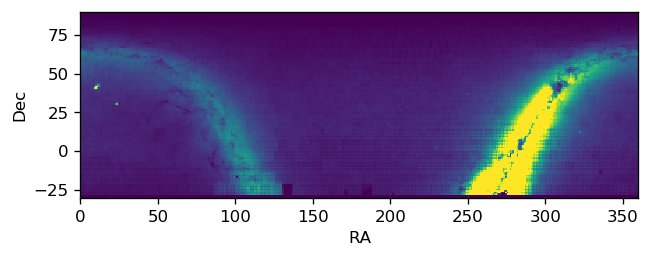

In [7]:
%%time
x,y,hist = histogram2d(ztf, ztf['ra'], ztf['dec'], 400, 120, min1=0, max1=360, min2=-30, max2=90)

extent = (0, 360, -30, 90)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.4*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

In [32]:
sesar = catalog.load("sesar_rrlyrae")

In [33]:
%%time
xmatch = sesar.crossmatch(ztf, return_min=True)

x,y,hist = histogram2d(xmatch, xmatch['ra'], xmatch['dec'], 400, 120, min1=0, max1=360, min2=-30, max2=90)


/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


CPU times: user 132 ms, sys: 61.9 ms, total: 194 ms
Wall time: 7min 20s


Text(0, 0.5, 'Dec')

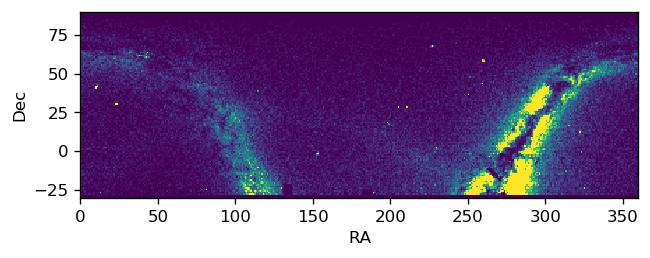

In [35]:
extent = (0, 360, -30, 90)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.1*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

In [ ]:
3